In [1]:
import os
import pathlib
import opensmile

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers.experimental import preprocessing

import matplotlib.pyplot as plt

In [2]:
data_path = '/tf/app/data/ADReSS-IS2020' # change this 
audio_path_cc = data_path + '/Full_wave_enhanced_audio/cc/'
audio_path_cd = data_path + '/Full_wave_enhanced_audio/cd/'


text_path_cc = data_path + '/transcription/cc/'
text_path_cd = data_path + '/transcription/cd/'

In [3]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()

In [4]:
meta["ID"] = meta["ID"].str.strip()

In [5]:
ad_files = [str(f) for f in pathlib.Path(audio_path_cd).glob('*.wav')]
control_files = [str(f) for f in pathlib.Path(audio_path_cc).glob('*.wav')]

In [6]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)

In [7]:
ad_data = smile.process_files(ad_files)
control_data = smile.process_files(control_files)

In [8]:
def add_MMSE(data):
    data.reset_index(inplace=True)
    data["file"] = data["file"].str.split("/").str[-1].str.split('.wav').str[0]
    data = data.merge(meta[["ID", "MMSE"]], how="inner", left_on="file", right_on="ID").drop("ID", axis=1)
    data.set_index(["file","start","end"], inplace=True)
    return data

ad_data = add_MMSE(ad_data)
control_data = add_MMSE(control_data)

In [9]:
data = pd.concat([ad_data,control_data])

In [10]:
data = data.sample(frac=1)

In [11]:
data = data[data["MMSE"]!=' NA']
data["MMSE"] = data["MMSE"].astype(float)

In [12]:
train_cutoff = int(len(data)*0.7)
val_cutoff = int(len(data)*0.85)

train = data[:train_cutoff]
val = data[train_cutoff:val_cutoff]
test = data[val_cutoff:]

train_x = train.drop("MMSE", axis=1).to_numpy()
train_y = train["MMSE"].to_numpy()

val_x = val.drop("MMSE", axis=1).to_numpy()
val_y = val["MMSE"].to_numpy()

test_x = test.drop("MMSE", axis=1).to_numpy()
test_y = test["MMSE"].to_numpy()

In [13]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_x)

model = models.Sequential([
    layers.Input(shape=(6373,)),
    norm_layer,
    layers.Dense(2056, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='relu')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6373)              12747     
_________________________________________________________________
dense (Dense)                (None, 2056)              13104944  
_________________________________________________________________
dropout (Dropout)            (None, 2056)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1053184   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [14]:
model.compile(
    optimizer="adam",
    loss='mse',
    metrics=[tf.keras.losses.MeanSquaredError()]
)

In [15]:
EPOCHS = 100
history = model.fit(
    train_x,
    train_y,
    batch_size=64,
    epochs=EPOCHS,
    validation_data=(val_x, val_y)
)

Epoch 1/100
2/2 [==============================] - 1s 296ms/step - loss: 496.2222 - mean_squared_error: 395.3447 - val_loss: 1435732.8750 - val_mean_squared_error: 1435732.8750
Epoch 2/100
2/2 [==============================] - 0s 47ms/step - loss: 215.8638 - mean_squared_error: 209.0094 - val_loss: 586818.7500 - val_mean_squared_error: 586818.7500
Epoch 3/100
2/2 [==============================] - 0s 49ms/step - loss: 102.5193 - mean_squared_error: 105.6612 - val_loss: 199934.7812 - val_mean_squared_error: 199934.7812
Epoch 4/100
2/2 [==============================] - 0s 52ms/step - loss: 110.6555 - mean_squared_error: 105.7277 - val_loss: 191761.4062 - val_mean_squared_error: 191761.4062
Epoch 5/100
2/2 [==============================] - 0s 53ms/step - loss: 152.4055 - mean_squared_error: 169.8287 - val_loss: 207558.3438 - val_mean_squared_error: 207558.3438
Epoch 6/100
2/2 [==============================] - 0s 50ms/step - loss: 222.7461 - mean_squared_error: 262.0979 - val_loss: 146

Epoch 96/100
2/2 [==============================] - 0s 44ms/step - loss: 74.9675 - mean_squared_error: 79.7580 - val_loss: 47313.6914 - val_mean_squared_error: 47313.6914
Epoch 97/100
2/2 [==============================] - 0s 47ms/step - loss: 87.9410 - mean_squared_error: 113.3675 - val_loss: 51129.0273 - val_mean_squared_error: 51129.0273
Epoch 98/100
2/2 [==============================] - 0s 47ms/step - loss: 73.7625 - mean_squared_error: 66.6808 - val_loss: 54410.1094 - val_mean_squared_error: 54410.1094
Epoch 99/100
2/2 [==============================] - 0s 45ms/step - loss: 64.7811 - mean_squared_error: 76.4528 - val_loss: 52406.0000 - val_mean_squared_error: 52406.0000
Epoch 100/100
2/2 [==============================] - 0s 49ms/step - loss: 66.4725 - mean_squared_error: 85.2526 - val_loss: 48574.9141 - val_mean_squared_error: 48574.9141


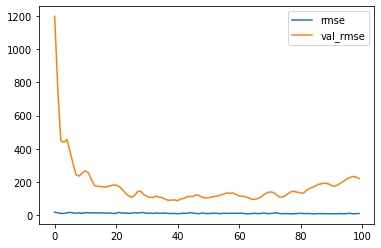

In [18]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['mean_squared_error']), np.sqrt(metrics['val_mean_squared_error']))
plt.legend(['rmse', 'val_rmse'])
plt.show()

In [17]:
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=64)
print("test rmse:", np.sqrt(results)[0])

Evaluate on test data
1/1 [==============================] - 0s 12ms/step - loss: 126.6833 - mean_squared_error: 126.6833
test rmse: 11.255365406207215
